# About this notebook
Notebook is used for experimenting the subtasks "grouping categorical features" and "feature selection".
Functions will then be modularized used in `data_cleaning.py` or `feature_selection.py`.

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import mutual_info_classif

sns.set_theme(style="whitegrid")
sns.set_palette(palette="Paired")

# Load Data

In [31]:
# Read provided data
x_train = pd.read_csv("../../data/raw/train_values.csv")
y_train = pd.read_csv("../../data/raw/train_labels.csv")
x_test = pd.read_csv("../../data/raw/test_values.csv")

x_train.set_index("building_id", inplace=True)
x_test.set_index("building_id", inplace=True)
y_train.set_index("building_id", inplace=True)

# Concat x_train and y_train for analysis: Drop building_id since its redundant then
df_train = pd.concat([x_train, y_train], axis=1)

# Print information about shape
print(f"Shape of train_values.csv: {x_train.shape}")
print(f"Shape of train_labels.csv: {y_train.shape}")
print(f"Shape of concat df_train to analyse: {df_train.shape}")

# Preview df
df_train.head(5)

Shape of train_values.csv: (260601, 38)
Shape of train_labels.csv: (260601, 1)
Shape of concat df_train to analyse: (260601, 39)


,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3
28830,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,2
94947,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3
590882,22,418,10694,2,10,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,2
201944,11,131,1488,3,30,8,9,t,r,n,...,0,0,0,0,0,0,0,0,0,3


# Grouping of categorical features

## Plot distribution of categorical features
We need this plot to do the mapping.

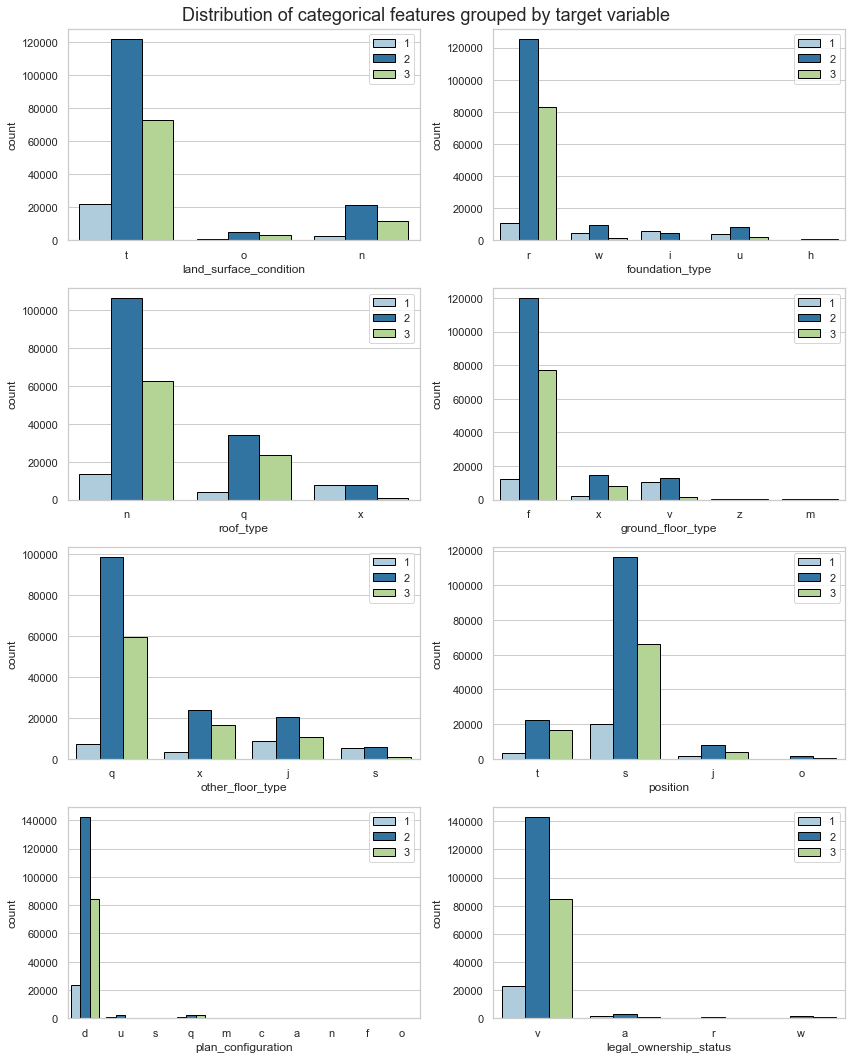

In [32]:
# First get columns to analyse (here: categorical ones)
categoric_columns = list(df_train.select_dtypes(include=['object']).columns)#.remove("building_id")
categoric_columns = categoric_columns + ["damage_grade"]
df_train_categoric = df_train[categoric_columns]
categoric_columns_wo_target = [x for x in categoric_columns if x != "damage_grade"]

# Dynamically set size of subplots
NCOLS: int = 2
NROWS: int = math.ceil(len(categoric_columns_wo_target)/NCOLS)

# Plot settings
fig, axes = plt.subplots(figsize=(12, 15), nrows=NROWS, ncols=NCOLS)
fig.suptitle("Distribution of categorical features grouped by target variable", size=18)
for feature, ax in zip(categoric_columns_wo_target, axes.flatten()):
    g=sns.countplot(data=df_train_categoric, x=feature, hue="damage_grade", edgecolor="black", ax=ax)
    ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

### Findings
Do mapping for
- plan_configuration
- legal_ownership_status
- ground_floor_type

## Define mappings and map function

In [33]:
def group_categorical_features(df: pd.DataFrame, default_val: str = "others", verbose: bool = False) -> pd.DataFrame:
    """
    Function that groups categorical features with many unique low populated realizations into "others".
    Significant for feature that have rarely occurring categorical values, e.g. "plan_configuration".
    Predefined mappings are within the function and contain the column to apply the mapping and the map itself.
    Not explicitly listed mappings are replaced with param "default_val", which is "others" (default)

    :param df: DataFrame to apply the mapping
    :param default_val: Default value to use for not explicit listed maps
    :param verbose: Bool whether to print information or not (default: False)

    :return: DataFrame with the column replaced with the mapped column
    """

    # Define mapping for each feature with rarely occuring categorical values
    mapping_plan_configuration = {"col": "plan_configuration",
                                  "mapping": {"d": "d"}}
    mapping_legal_ownership_status = {"col": "legal_ownership_status",
                                      "mapping": {"v": "v"}}
    mapping_ground_floor_type = {"col": "ground_floor_type",
                                 "mapping": {"f": "f", "x": "x", "v": "v"}}
    # Put in list for iteration
    mappings = [mapping_plan_configuration, mapping_legal_ownership_status, mapping_ground_floor_type]

    # Apply mapping for each mapping defined in mappings list
    for mapping in mappings:
        # Overwrite column to be mapped with mapped values
        df[mapping.get("col")] = df[mapping.get("col")].map(mapping.get("mapping")).fillna(default_val)
        if verbose:
            print(f"Applied mapping / grouping for feature '{mapping.get('col')}'")
    return df

df = df_train.copy()
df = group_categorical_features(df=df, default_val="others", verbose=True)

Applied mapping / grouping for feature 'plan_configuration'
Applied mapping / grouping for feature 'legal_ownership_status'
Applied mapping / grouping for feature 'ground_floor_type'


## Plot after Mapping

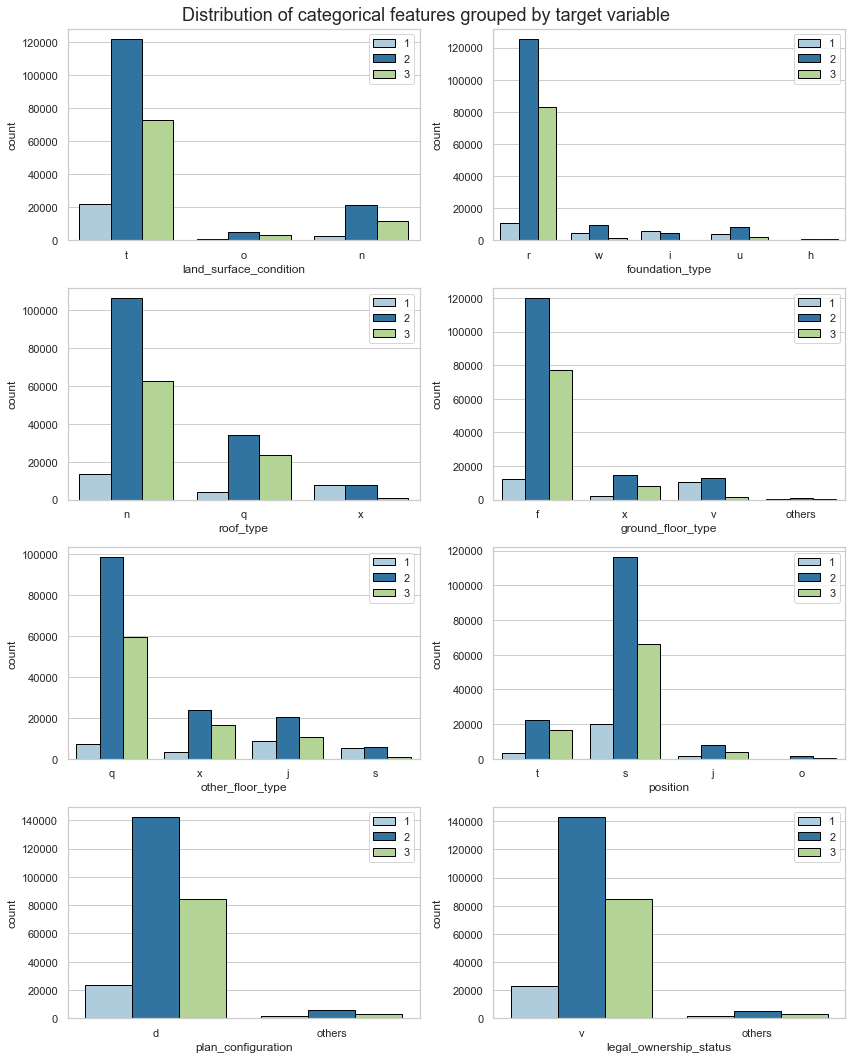

In [34]:
# Dynamically set size of subplots
NCOLS: int = 2
NROWS: int = math.ceil(len(categoric_columns_wo_target)/NCOLS)

# Plot settings
fig, axes = plt.subplots(figsize=(12, 15), nrows=NROWS, ncols=NCOLS)
fig.suptitle("Distribution of categorical features grouped by target variable", size=18)
for feature, ax in zip(categoric_columns_wo_target, axes.flatten()):
    g=sns.countplot(data=df, x=feature, hue="damage_grade", edgecolor="black", ax=ax)
    ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

_____
# Feature Selection using RFE

In [35]:
# Get train data and prepare for feature selection
x_train = group_categorical_features(x_train)

In [36]:
# Do some label encoding here for feature selection
x_train = pd.get_dummies(x_train)

# Make x_train and y_train bit smaller for my laptop to handle :-)
x_train = x_train.sample(frac=0.5)
y_train = y_train.loc[x_train.index]
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

x_train.head(5)

Shape of x_train: (130300, 57)
Shape of y_train: (130300, 1)


,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_d,plan_configuration_others,legal_ownership_status_others,legal_ownership_status_v
building_id,,,,,,,,,,,,,,,,,,,,,
33182,13,925,11990,2,20,4,5,0,1,0,...,0,0,0,0,1,0,1,0,0,1
455262,8,1073,162,3,20,8,7,0,1,0,...,0,0,0,0,1,0,1,0,0,1
503002,17,680,3222,2,35,20,5,0,1,0,...,0,0,0,0,1,0,1,0,0,1
130220,17,1352,4953,2,20,9,5,0,1,0,...,0,0,0,0,0,1,1,0,0,1
106528,15,620,6545,2,30,6,5,0,1,0,...,0,0,0,0,1,0,1,0,0,1


In [38]:
y_train.head(5)

,damage_grade
building_id,
33182,2
455262,2
503002,3
130220,3
106528,2


In [39]:
def get_top_k_features_using_rfe(x_train: pd.DataFrame, y_train: pd.DataFrame, k = 0.50, step: int = 2, verbose: int = 0):
    """
    Applies Recursive Feature Elimination to get the best k features. Note that k can either be a integer, or a float.
    If it is a float, e.g. 0.5, then 50% of the total features, that are estimated to be relevant, will be selected.
    Uses a RandomForest as a classifier and therefore the _feature_importances as a scoring.

    :param x_train: DataFrame of the training data
    :param y_train: Dataframe of the labels
    :param k: Int or float: Number of features to be selected. The smaller it is, the more computation power is needed.
    :param step: Step size of the feature elimination. The smaller it is, the more computation power is needed.
    :param verbose: Verbosity level. Set to 0 to be quiet.

    :return: List of k top features, Fitted RFE object
    """

    # Define classifier
    clf = RandomForestClassifier()
    rfe = RFE(estimator=clf, n_features_to_select=k, step=step, verbose=verbose)
    rfe.fit(x_train, y_train["damage_grade"].values.flatten())

    # Select feature name that are estimated to be the best features
    ranking = pd.DataFrame({"feature": x_train.columns, "rfe_support": rfe.support_})
    best_k_features = ranking[ranking["rfe_support"] == True]["feature"].to_list()

    return best_k_features, rfe

best_k_features, rfe = get_top_k_features_using_rfe(x_train=x_train, y_train=y_train, k=0.75, verbose=1)
print(best_k_features)

Fitting estimator with 57 features.
Fitting estimator with 55 features.
Fitting estimator with 53 features.
Fitting estimator with 51 features.
Fitting estimator with 49 features.
Fitting estimator with 47 features.
Fitting estimator with 45 features.
Fitting estimator with 43 features.
['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_other', 'count_families', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'land_surface_condition_n', 'land_surface_condition_o', 'land_surface_condition_t', 'foundation_type_i', 'foundation_type_r', 'foundation_type_w', 'roof_type_n', 'roof_type_q', 

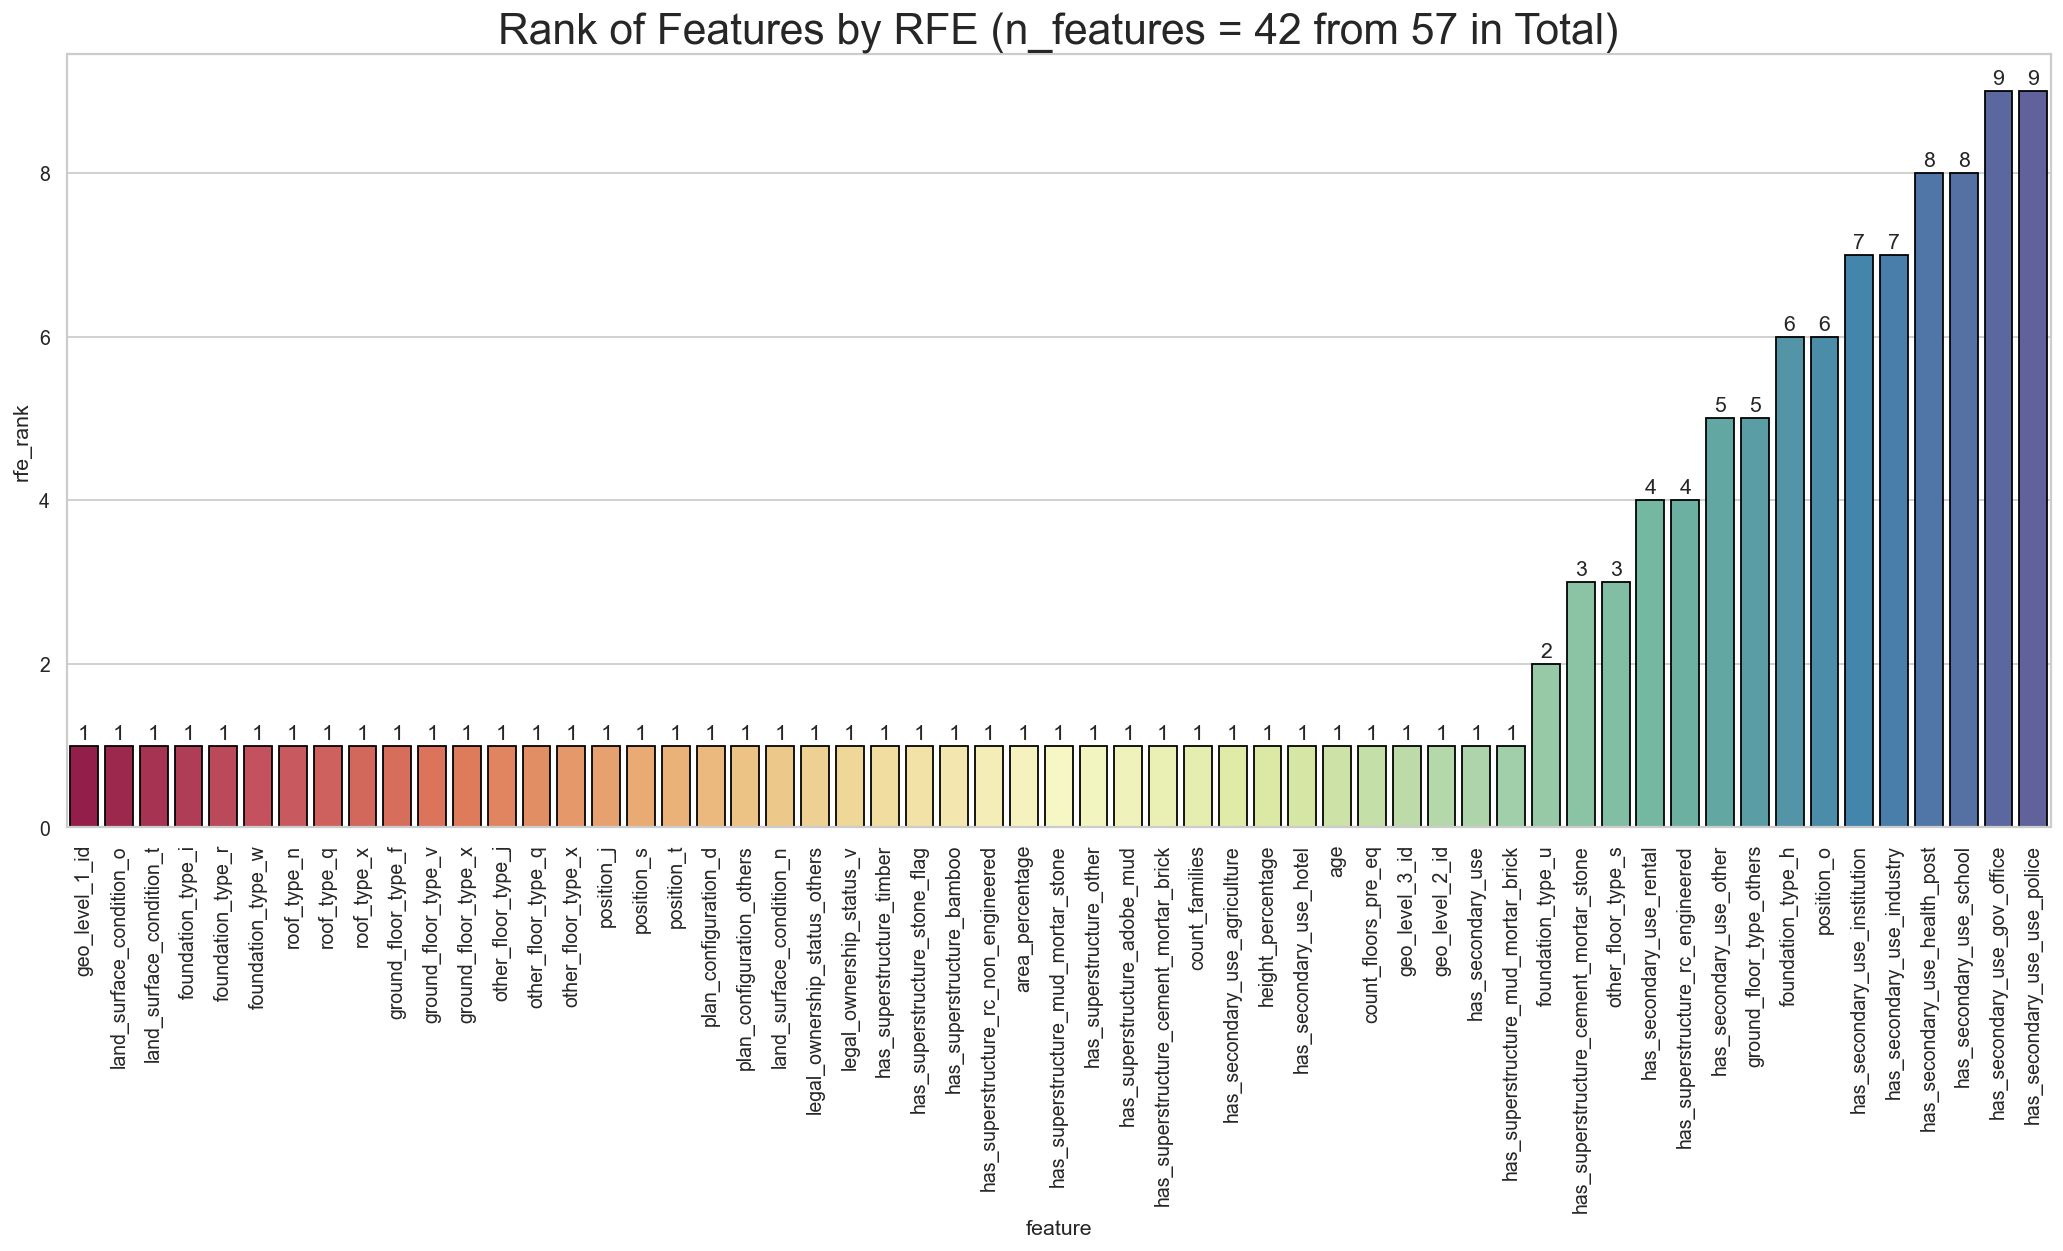

In [148]:
def plot_rfe_ranking(rfe: RFE):
    """
    Plots results from RFE, i.e. feature and its rank in barplot.

    :param rfe: Fitted RFE object; Gets returned from 'get_top_k_features_using_rfe' function
    :return: None
    """

    # Create dataframe for plotting
    res = pd.DataFrame({"feature": rfe.feature_names_in_, "rfe_rank": rfe.ranking_})
    res = res.sort_values(by="rfe_rank")

    # Plot settings
    plt.figure(figsize=(20, 8), dpi=128)
    plt.title(f"Rank of Features by RFE (n_features = {rfe.n_features_} from {rfe.n_features_in_} in Total)", size=24)
    g = sns.barplot(data=res, x="feature", y="rfe_rank", edgecolor="black", palette="Spectral")
    plt.xticks(rotation=90)
    plt.bar_label(g.containers[0], padding=1.5)
    plt.show()

plot_rfe_ranking(rfe)

# Feature Selection using Mutual Information
In comparison to RFE, Feature Selection using Mutual Information is much less computational heavy.

In [111]:
def get_top_k_features_using_mi(x_train: pd.DataFrame, y_train: pd.DataFrame, k: int = 30):
    """
    Computes the Mutual Information to the label and outputs the top k features as a list

    :param x_train: DataFrame of the train values
    :param y_train: DataFrame of the labels
    :param k: Number of top k features to output as list

    :return: List of top k features based on Mutual Information score
    """

    # Compute mutual information scores
    mi_scores = mutual_info_classif(x_train, y_train.values.flatten())
    mi_scores = pd.Series(mi_scores)
    mi_scores.index = x_train.columns

    # Sorts descending based on mi score and gets k first features
    top_k_features =  mi_scores.sort_values(ascending=False)[: k].keys().tolist()

    return top_k_features, mi_scores

top_k_features_mi, mi_scores = get_top_k_features_using_mi(x_train, y_train)

In [139]:
def get_comparison_df_rfe_mi(rfe: RFE, mi_scores: list, sort_by = "mi_score", ascending=False):
    ""
    comparison = pd.DataFrame({"rfe_rank": rfe.ranking_, "mi_score": mi_scores})
    comparison.sort_values(by=sort_by, ascending=ascending, inplace=True)

    return comparison

get_comparison_df_rfe_mi(rfe=rfe, mi_scores=mi_scores, sort_by="mi_score")

,rfe_rank,mi_score
geo_level_3_id,1,0.288866
geo_level_2_id,1,0.233712
geo_level_1_id,1,0.133904
foundation_type_r,1,0.075108
has_superstructure_mud_mortar_stone,1,0.058321
ground_floor_type_v,1,0.048985
ground_floor_type_f,1,0.039068
roof_type_x,1,0.038696
foundation_type_i,1,0.036257
other_floor_type_q,1,0.032822


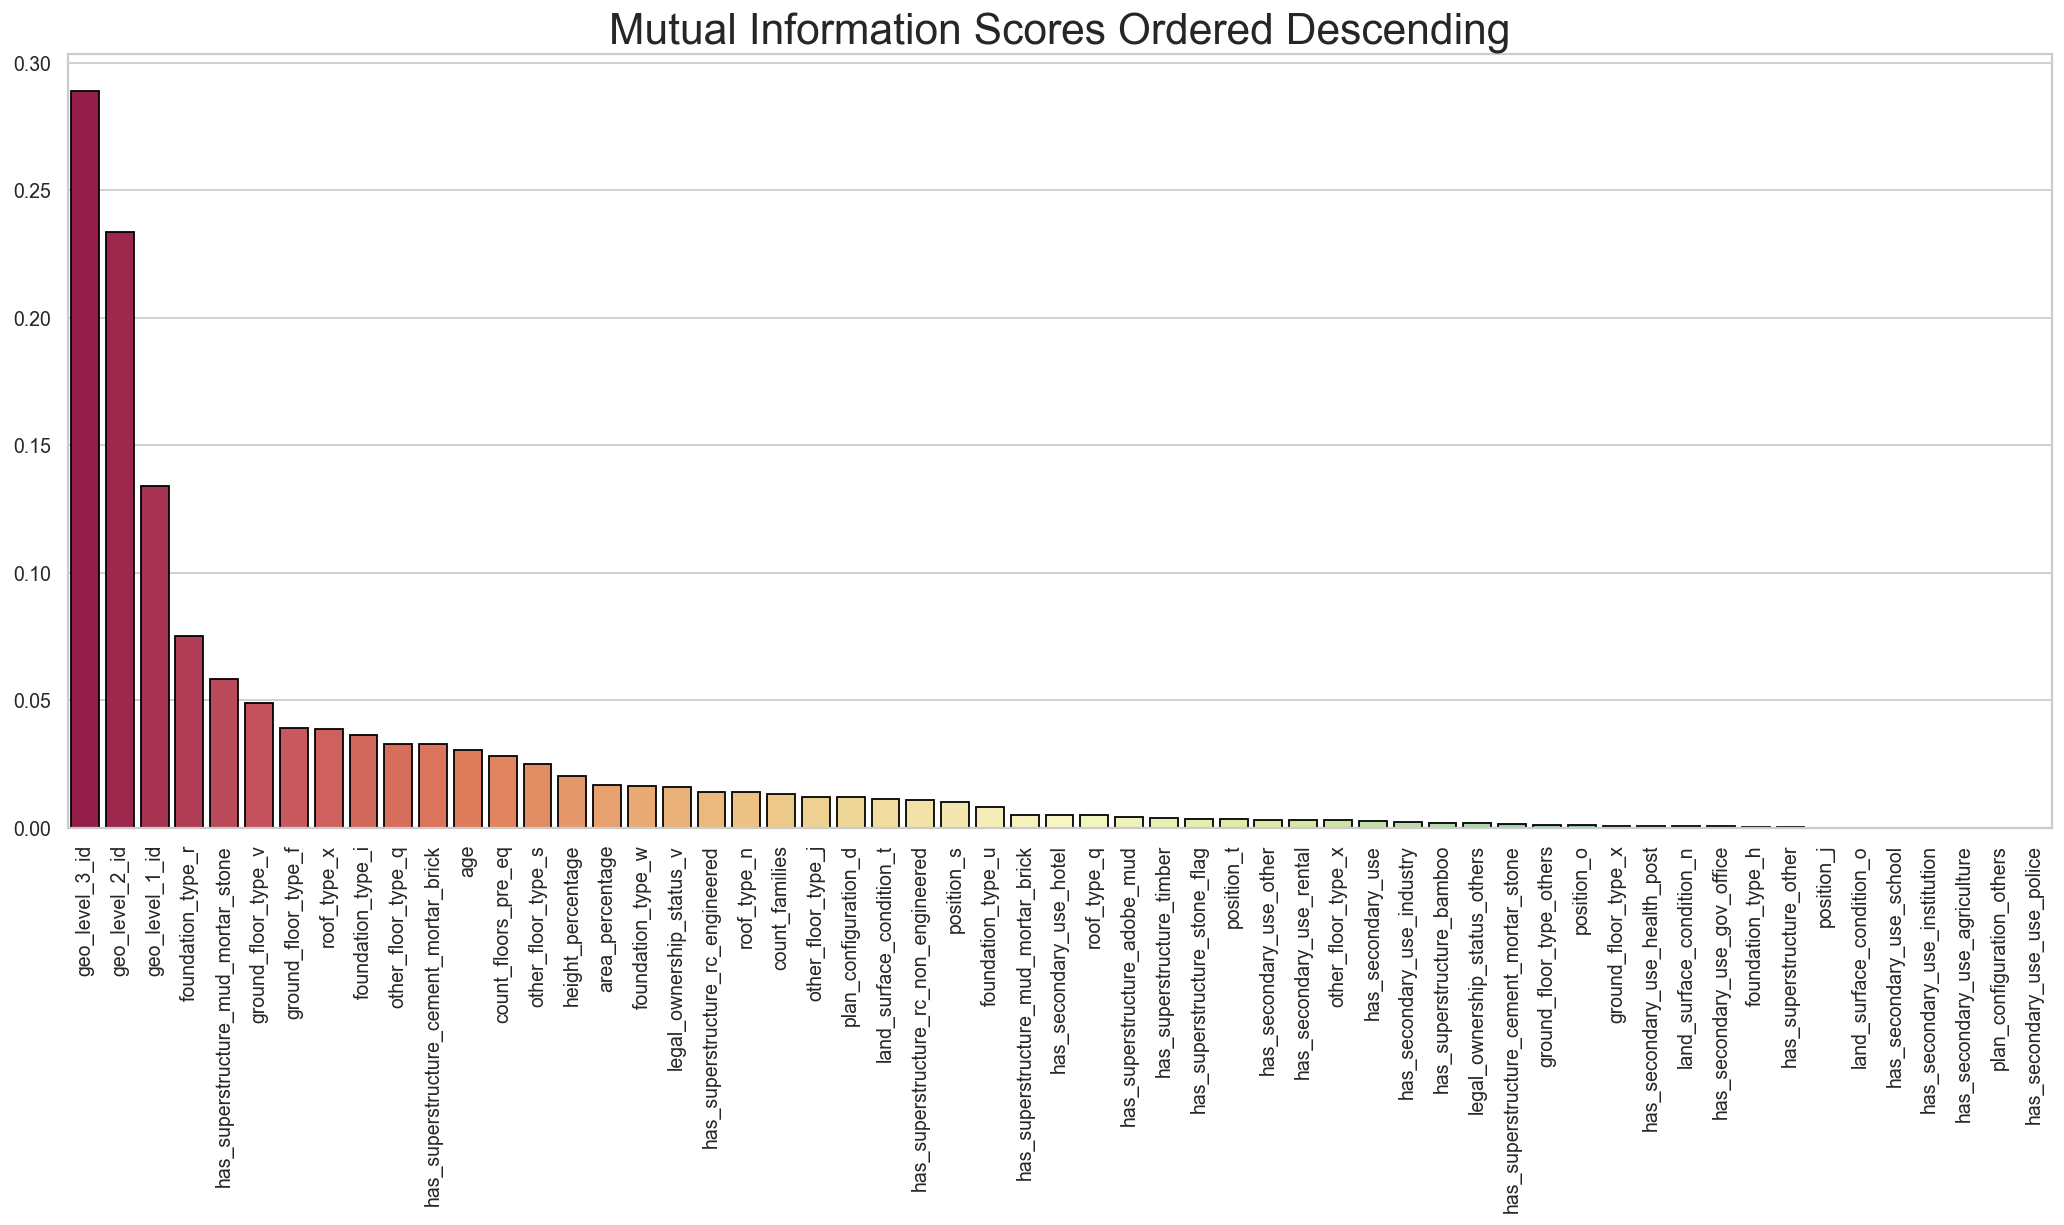

In [152]:
def plot_mi_ranking(mi_scores):
    """
    Plots results of the Mutual Information Score.

    :param mi_scores: Pandas Series -- Output of the get_top_k_features_using_mi function
    :return: None
    """

    mi_scores.sort_values(ascending=False, inplace=True)
    plt.figure(figsize=(20,8), dpi=128)
    plt.title("Mutual Information Scores Ordered Descending", size=24)
    g = sns.barplot(x=mi_scores.keys(), y=mi_scores.values, palette="Spectral", edgecolor="black")
    plt.xticks(rotation=90)
    plt.show()

plot_mi_ranking(mi_scores)